<a href="https://colab.research.google.com/github/Ashraf-Al-Aodat/Customer-Groups-Predictive/blob/main/Customer_Groups_Predictive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret --quiet # install pycaret
!pip install --upgrade plotly # install/upgrade plotly
!pip install jupyter-dash # install dash

In [291]:
# import the required libs.
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# statistics and econometrics
import statsmodels.formula.api as smf          
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# pycaret
from pycaret.regression import *

from pycaret.utils import check_metric

from pycaret.utils import enable_colab

enable_colab()

# plots
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output 

import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px

import plotly.io as pio

pio.renderers.default = 'colab'

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
  
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

def showFig(fig):
  '''
  Todo: add des for the funation !!
  '''
  # build jupyter dash app 
  app = JupyterDash(__name__)
  # add html components and figure to app
  app.layout = html.Div([dcc.Graph(figure=fig)])
  # run app inline
  app.run_server(mode='inline')

Colab mode enabled.


In [3]:
# load the data file 
df = pd.read_csv('training.csv')

df.purchase_date = pd.to_datetime(df.purchase_date)

df.columns = ['Order', 'Contact','Date', 'Product', 'Quantity', 'Sales']

df.head()

Order   Contact       Date   Product  Quantity  Sales
0   4852169  17846335 2012-01-01   3308032         1  18.71
1   3570597  18759585 2012-01-01  37220513         2  83.50
2  32096674   5025194 2012-01-01  10259603         1  19.95
3   2904402  29624779 2012-01-01   3308032         1  18.71
4  38369470  42287117 2012-01-01   3308032         1  18.71

## Monthly Revenue Metric Analyze 📊



In [17]:
# extract the Date and the Sales then convarted to monthly based 
monthly_sales = pd.DataFrame({'Date': df.Date.dt.strftime('%Y-%m'), 'Sales': df.Sales})
monthly_sales = monthly_sales.groupby(['Date']).sum().round().reset_index()
monthly_sales.head()

Date      Sales
0  2012-01  1767727.0
1  2012-02  1491336.0
2  2012-03  1620713.0
3  2012-04  1515504.0
4  2012-05  1639885.0

In [18]:
# plot the monthly sales
fig = px.line(monthly_sales, x='Date', y='Sales', render_mode='webgl', title='Monthly Sales')
showFig(fig)

<IPython.core.display.Javascript object>

from the plot we can see that the sales has a vary interesting behavior on nov and dec then a big drop 🤔

In [19]:
# calculating the percentage of change between the current and a prior month.
monthly_sales['MonthlyGrowth'] = monthly_sales.Sales.pct_change()
monthly_sales.head()

Date      Sales  MonthlyGrowth
0  2012-01  1767727.0            NaN
1  2012-02  1491336.0      -0.156354
2  2012-03  1620713.0       0.086752
3  2012-04  1515504.0      -0.064915
4  2012-05  1639885.0       0.082072

In [27]:
# visualization line graph
fig = px.line(monthly_sales, 
                 x=monthly_sales[monthly_sales.Date < monthly_sales.Date.max()]['Date'], # the data sales excluding the last month
                 y=monthly_sales[monthly_sales.Date < monthly_sales.Date.max()]['MonthlyGrowth'],  # the monthly growth sales excluding the last month
                 labels={"x": "Date","y": "Monthly Growth",},
                 title='Montly Growth Rate')
showFig(fig)

<IPython.core.display.Javascript object>

same here more investigation needed 🤨

In [38]:
# calculating the monthy active user aka buy shonthing in that month. the user contact(id) show up in that month.
monthly_active = pd.DataFrame({'Date': df.Date.dt.strftime('%Y-%m'), 'Contact': df.Contact})
monthly_active = monthly_active.groupby(['Date']).nunique().reset_index()
monthly_active.head()

Date  Contact
0  2012-01    18942
1  2012-02    15053
2  2012-03    15783
3  2012-04    15118
4  2012-05    17190

In [30]:
#plotting the monthly active users
fig = px.bar(monthly_active, x='Date', y='Contact', title='Monthly Active Customers')
showFig(fig)

<IPython.core.display.Javascript object>

In [31]:
# calculating the number of sold items in a monthly based.
monthly_sale_quantity = pd.DataFrame({'Date': df.Date.dt.strftime('%Y-%m'), 'Quantity': df.Quantity})
monthly_sale_quantity = monthly_sale_quantity.groupby(['Date']).sum().reset_index()
monthly_sale_quantity.head()

Date  Quantity
0  2012-01     33195
1  2012-02     26045
2  2012-03     28114
3  2012-04     28048
4  2012-05     33339

In [32]:
# plotting the monthly total number of orders.
fig = px.bar(monthly_sale_quantity, x='Date', y='Quantity', title='Monthly Total # of Order')
showFig(fig)

<IPython.core.display.Javascript object>

In [121]:
# calculating the avg of orders in a monthly based.
monthly_order_avg = pd.DataFrame({'Date': df.Date.dt.strftime('%Y-%m'), 'Quantity': df.Sales})
monthly_order_avg = monthly_order_avg.groupby('Date').mean().reset_index()
monthly_order_avg.head()

Date   Quantity
0  2012-01  63.607887
1  2012-02  69.049707
2  2012-03  69.276027
3  2012-04  66.280524
4  2012-05  61.842775

In [122]:
# plotting the monthly orders avg.
fig = px.bar(monthly_order_avg, x='Date', y='Quantity', title='Monthly Order Average')
showFig(fig)

<IPython.core.display.Javascript object>

In [116]:
# adding a new user tag by calculating the min date the contant(id) added to the data.
min_purchase = pd.DataFrame({'Date': df.Date.dt.strftime('%Y-%m'), 'Contact': df.Contact})
min_purchase = min_purchase.groupby('Contact').min().reset_index()
min_purchase.columns = ['Contact','MinPurchaseDate']
min_purchase.MinPurchaseDate = pd.to_datetime(min_purchase.MinPurchaseDate)

min_purchase = pd.merge(min_purchase, pd.DataFrame({'Date': pd.to_datetime(df.Date.dt.strftime('%Y-%m')),
                                                    'Contact': df.Contact, 'Sales': df.Sales}), on='Contact')

min_purchase['UserType'] = 'New' # add all user as new.
min_purchase.loc[min_purchase['Date'] > min_purchase['MinPurchaseDate'], 'UserType'] = 'Existing' 

user_type_sales = min_purchase.groupby(['Date','UserType'])['Sales'].sum().reset_index()

user_type_sales.head()

Date  UserType         Sales
0 2012-01-01       New  1.767727e+06
1 2012-02-01  Existing  2.274740e+05
2 2012-02-01       New  1.263862e+06
3 2012-03-01  Existing  3.122485e+05
4 2012-03-01       New  1.308464e+06

In [115]:
# plot the user type result.
fig = px.bar(user_type_sales, x='Date', y='Sales', color='UserType', title='New vs Existing')
fig.update_traces(hovertemplate=None)
fig.update_layout(hovermode="x")
showFig(fig)

<IPython.core.display.Javascript object>

this plot indicate that to company need to focus on retention customers 🧐<br>
lets see ... 🔍

In [118]:
retention = pd.DataFrame({'Date': df.Date.dt.strftime('%Y-%m'), 'Contact': df.Contact, 'Sales': df.Sales})
retention = retention.groupby(['Contact','Date'])['Sales'].sum().reset_index()

#create retention matrix with crosstab
retention = pd.crosstab(retention['Contact'], retention['Date']).reset_index()

#create an array of dictionary which keeps Retained & Total User count for each month
months = retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['Date'] = pd.to_datetime(selected_month)
    retention_data['TotalUserCount'] = retention[selected_month].sum()
    retention_data['RetainedUserCount'] = retention[(retention[selected_month] > 0) & (retention[prev_month] > 0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
retention = pd.DataFrame(retention_array)
retention['RetentionRate'] = retention['RetainedUserCount'] / retention['TotalUserCount']

retention.head()

Date  TotalUserCount  RetainedUserCount  RetentionRate
0 2012-03-01           15783               1358       0.086042
1 2012-04-01           15118               1383       0.091480
2 2012-05-01           17190               1359       0.079058
3 2012-06-01           16929               1576       0.093095
4 2012-07-01           16234               1494       0.092029

In [120]:
fig = px.scatter(retention, x='Date', y='RetentionRate', title='Monthly Retention Rate')
fig.update_traces(mode="markers+lines")
showFig(fig)

<IPython.core.display.Javascript object>

as it seem the company need to try somehting to keep old customers coming back maybe loyalty strategy.

## Customer Segmentation (RFM) 👨‍💻

To understand customers behavior.

In [280]:
rfm = df.copy()
rfm['Date'] = rfm.Date.dt.strftime('%Y-%m')

In [281]:
user = pd.DataFrame(rfm['Contact'].unique())
user.columns = ['Contact']

# get the max purchase date for each customer and create a dataframe with it
max_purchase = df.groupby('Contact').Date.max().reset_index()
max_purchase.columns = ['Contact','MaxPurchaseDate']

# take our observation point as the max invoice date in our data
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days

# merge this dataframe to our new user dataframe
user = pd.merge(user, max_purchase[['Contact','Recency']], on='Contact')
user = user.dropna()

user

Contact  Recency
0       17846335      330
1       18759585      730
2        5025194      106
3       29624779      415
4       42287117      184
...          ...      ...
262290  18593837        0
262291  49274093        0
262292  21548682        0
262293  23136841        0
262294   2444081        0

[262295 rows x 2 columns]

In [282]:
#plot the recency histogram
fig = px.histogram(user, x=['Recency'], title='Recency')
plot_data = [
    go.Histogram(
        x=user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
showFig(fig)

<IPython.core.display.Javascript object>

In [283]:
display(user.Recency.describe())
user.Recency.skew()

count    262295.000000
mean        362.128508
std         215.060907
min           0.000000
25%         173.000000
50%         385.000000
75%         544.000000
max         730.000000
Name: Recency, dtype: float64

-0.06765140738291897

In [292]:
# build a recency socre using Kmeans cluster
from sklearn.cluster import KMeans

sse={}
recency = user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 

configure_plotly_browser_state()

# plot the histogram
plot_data = [
    go.Line(
        x=list(sse.keys()),
        y=list(sse.values())
    )
]

plot_layout = go.Layout(
        title='Number of cluster'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [285]:
#build 4 clusters for recency and add it to dataframe; why 4 will look at the above plot we can see the line settle down
kmeans = KMeans(n_clusters=4)
recency = user[['Recency']]
kmeans.fit(recency)
user['RecencyCluster'] = kmeans.predict(recency)

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name, df, ascending):
  '''
  '''
  new_cluster_field_name = 'new_' + cluster_field_name
  df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
  df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
  df_new['index'] = df_new.index
  df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
  df_final = df_final.drop([cluster_field_name], axis=1)
  df_final = df_final.rename(columns={"index":cluster_field_name})
  return df_final

user = order_cluster('RecencyCluster', 'Recency', user, False)
user.describe()

Contact        Recency  RecencyCluster
count  2.622950e+05  262295.000000   262295.000000
mean   2.498982e+07     362.128508        1.361193
std    1.442812e+07     215.060907        1.107000
min    2.200000e+01       0.000000        0.000000
25%    1.249407e+07     173.000000        0.000000
50%    2.500126e+07     385.000000        1.000000
75%    3.746457e+07     544.000000        2.000000
max    4.999980e+07     730.000000        3.000000

In [286]:
user.groupby('RecencyCluster')['Recency'].describe()

count        mean        std  ...    50%    75%    max
RecencyCluster                                  ...                     
0               72711.0  626.652955  61.234962  ...  625.0  681.0  730.0
1               79877.0  421.456590  52.703120  ...  413.0  466.0  523.0
2               51964.0  233.263201  50.986607  ...  231.0  275.0  326.0
3               57743.0   62.933291  41.800706  ...   54.0   97.0  147.0

[4 rows x 8 columns]

In [ ]:
frequency = rfm.groupby('Contact').Date.count().reset_index()
frequency.columns = ['Contact','Frequency']

#add this data to our main dataframe
user = pd.merge(user, frequency, on='Contact')
user.head()

In [ ]:
#plot the histogram
fig = px.histogram(frequency, x=frequency[frequency.Frequency < 300]['Frequency'], title='Frequency', labels={'count': 'Frequency', 'x': ''})
showFig(fig)

In [ ]:
# k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Frequency']])
user['FrequencyCluster'] = kmeans.predict(user[['Frequency']])

# order the frequency cluster
user = order_cluster('FrequencyCluster', 'Frequency', user, True)

# see details of each cluster
user.groupby('FrequencyCluster')['Frequency'].describe()

In [ ]:
configure_plotly_browser_state()
# calculate sales for each customer
sales = rfm.groupby('Contact').Sales.sum().reset_index()

# merge it with the main data
user = pd.merge(user, sales, on='Contact')

# plot the histogram
plot_data = [
    go.Histogram(
        x=user[user.Sales < 10000]['Sales']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [ ]:
# apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Sales']])
user['SalesCluster'] = kmeans.predict(user[['Sales']])


# order the cluster numbers
user = order_cluster('SalesCluster', 'Sales', user, True)

# show details of the dataframe
user.groupby('SalesCluster')['Sales'].describe()

In [ ]:
user['OverallScore'] = user['RecencyCluster'] + user['FrequencyCluster'] + user['SalesCluster']
user.groupby('OverallScore')['Recency','Frequency','Sales'].mean()

The scoring above clearly shows us that customers with score 8 is our best customers where as 0 is the worst.

To keep things simple, better we name these scores:

*    0 to 2: Low Value
*   3 to 4: Mid Value
*   5+: High Value

In [ ]:
user['Segment'] = 'Low-Value'
user.loc[user['OverallScore'] > 2,'Segment'] = 'Mid-Value' 
user.loc[user['OverallScore'] > 4,'Segment'] = 'High-Value' 
user.head()

In [ ]:
def rfm_show(graph, x, y):
  '''
  To help see rfm with each other.
  '''
  plot_data = [
      go.Scattergl(
          x=graph.query("Segment == 'Low-Value'")[x],
          y=graph.query("Segment == 'Low-Value'")[y],
          mode='markers',
          name='Low',
          marker= dict(size= 7,
              line= dict(width=1),
              color= 'blue',
              opacity= 0.8
            )
      ),
          go.Scattergl(
          x=graph.query("Segment == 'Mid-Value'")[x],
          y=graph.query("Segment == 'Mid-Value'")[y],
          mode='markers',
          name='Mid',
          marker= dict(size= 9,
              line= dict(width=1),
              color= 'green',
              opacity= 0.5
            )
      ),
          go.Scattergl(
          x=graph.query("Segment == 'High-Value'")[x],
          y=graph.query("Segment == 'High-Value'")[y],
          mode='markers',
          name='High',
          marker= dict(size= 11,
              line= dict(width=1),
              color= 'red',
              opacity= 0.9
            )
      ),
  ]

  plot_layout = go.Layout(
          yaxis= {'title': y},
          xaxis= {'title': x},
          title='Segments'
      )
  fig = go.Figure(data=plot_data, layout=plot_layout)
  showFig(fig)

In [ ]:
#Sales vs Frequency
rfm_show(user.query("Sales < 50000 and Frequency < 2000"), 'Sales', 'Frequency')

In [ ]:
# Sales vs Recency
rfm_show(user.query("Sales < 50000 and Frequency < 2000"), 'Sales', 'Recency')

In [ ]:
# Recency vs Frequency
rfm_show(user.query("Sales < 50000 and Frequency < 2000"), 'Recency', 'Frequency')

*   High Value: Improve Retention
*   Mid Value: Improve Retention + Increase Frequency
*   Low Value: Increase Frequency


# PyCaret a low code lib for ML 😊
The reason to use it is to speed thing up and i wanted to try it. 

In this section i will answer the question in the Assignment.

Aka what is the total sales for the next year for the group of customer in some month.

## Daily based predictions. predicting the salse of the next day ↗

In [185]:
# calculate sales in each day. The strftime function help us to convert the dates to a daily base.
data = pd.DataFrame({'Date': df.Date.dt.strftime('%Y-%m-%d'), 'Sales': df.Sales}) # copy df with only the Date and Sales columns
data = data.groupby('Date').sum().reset_index() # group the data based on the date then sum sales of each day.
data.head()

Date     Sales
0  2012-01-01  44629.13
1  2012-01-02  60111.64
2  2012-01-03  72496.98
3  2012-01-04  67425.77
4  2012-01-05  80409.30

In [184]:
# plot the daily sums of sales
fig = px.line(data, x='Date', y='Sales', title='Daily Sales')
showFig(fig)

<IPython.core.display.Javascript object>

the data seems to be not stationary lets try Dickey-Fuller test 🔍. 

In [166]:
def dickeyFullerTest(y, lags=None, figsize=(12, 7), style='bmh'):
  """
      Plot time series, its ACF and PACF, calculate Dickey–Fuller test
      
      y - timeseries
      lags - how many lags to include in ACF, PACF calculation
  """
  if not isinstance(y, pd.Series):
    y = pd.Series(y)

  result = sm.tsa.stattools.adfuller(y, autolag='AIC')
  text = 'Statistic: {0:.5f}  '.format(result[0])
  text += 'p: {0:.5f}  '.format(result[1])
  text += '   n_lags: {0:.5f}'.format(result[1])
  text += '\nCritial Values:  '
  for key, value in result[4].items():
    text += ' {}:'.format(key)
    text += ' {}  '.format(value)

  with plt.style.context(style):    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=ts_ax)
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller:    ' + text)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

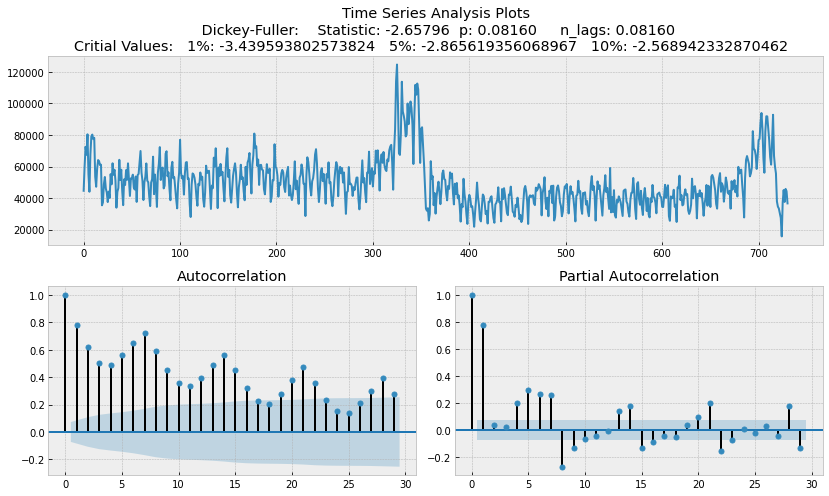

In [167]:
dickeyFullerTest(data.Sales)

it seems to be true (strong). now we need to fight non-stationarity we can  uses one of more of those approaches: 

*   various order differences
*   trend and seasonality removal
*   smoothing
*   transformations like Box-Cox or logarithmic.

i will go with the differences , seasonality removal and the transformation.

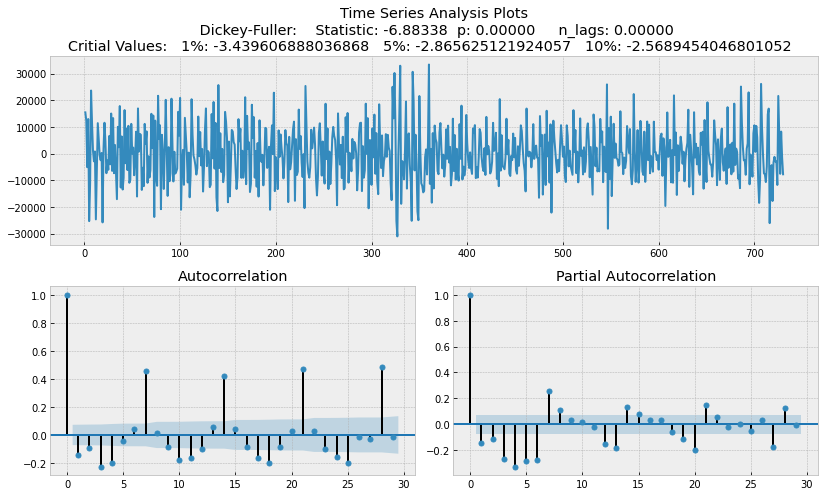

In [173]:
dickeyFullerTest(data.Sales.diff(1).dropna())

In [196]:
# build the data and do feature exctraction then split the data to train and test sets
# side note we can exctract features like is the day a holiday an event maybe
# the max/min value of series in a window
# the average/median value in a window
# the window variance
# here i will do 1 day lag window and 1 day difference 
train = data.copy()
train['Diff'] = train.Sales.diff(1) # diff of sales
train['Lag_1'] = train.Sales.shift(1) # lag of sales
train = train.dropna()
unseen = train[-30:] # the test seet 30 day a month.
train = train[:-30] 
print('train set shape: ',train.shape, '  test set shape ', unseen.shape)
train.head()

train set shape:  (700, 4)   test set shape  (30, 4)


Date     Sales      Diff     Lag_1
1  2012-01-02  60111.64  15482.51  44629.13
2  2012-01-03  72496.98  12385.34  60111.64
3  2012-01-04  67425.77  -5071.21  72496.98
4  2012-01-05  80409.30  12983.53  67425.77
5  2012-01-06  55132.92 -25276.38  80409.30

now let try to build, train then predict.

In [197]:
# initialize the setup for pycaret
s = setup(train, target = 'Sales', normalize=True, transformation=True, ignore_features=['Date'],
          data_split_shuffle= False, fold_strategy = 'timeseries', fold = 3, transform_target = True, session_id = 123)

Description             Value
0                               session_id               123
1                                   Target             Sales
2                            Original Data          (700, 4)
3                           Missing Values             False
4                         Numeric Features                 2
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set          (489, 2)
10                    Transformed Test Set          (211, 2)
11                      Shuffle Train-Test             False
12                     Stratify Train-Test             False
13                          Fold Generator   TimeSeriesSplit
14                             Fold Number                 3
15                                CPU Jobs                -1
16                                 Use GPU             False
17                          Log Experiment             False
18                         Experiment Name  reg-default-name
19                                     USI              6854
20                         Imputation Type            simple
21          Iterative Imputation Iteration              None
22                         Numeric Imputer              mean
23      Iterative Imputation Numeric Model              None
24                     Categorical Imputer          constant
25  Iterative Imputation Categorical Model              None
26           Unknown Categoricals Handling    least_frequent
27                               Normalize              True
28                        Normalize Method            zscore
29                          Transformation              True
30                   Transformation Method       yeo-johnson
31                                     PCA             False
32                              PCA Method              None
33                          PCA Components              None
34                     Ignore Low Variance             False
35                     Combine Rare Levels             False
36                    Rare Level Threshold              None
37                         Numeric Binning             False
38                         Remove Outliers             False
39                      Outliers Threshold              None
40                Remove Multicollinearity             False
41             Multicollinearity Threshold              None
42                              Clustering             False
43                    Clustering Iteration              None
44                     Polynomial Features             False
45                       Polynomial Degree              None
46                    Trignometry Features             False
47                    Polynomial Threshold              None
48                          Group Features             False
49                       Feature Selection             False
50                Feature Selection Method           classic
51            Features Selection Threshold              None
52                     Feature Interaction             False
53                           Feature Ratio             False
54                   Interaction Threshold              None
55                        Transform Target              True
56                 Transform Target Method           box-cox

In [198]:
# the models available in pycaret 23 one
models()

Name  ...  Turbo
ID                                           ...       
lr                        Linear Regression  ...   True
lasso                      Lasso Regression  ...   True
ridge                      Ridge Regression  ...   True
en                              Elastic Net  ...   True
lar                  Least Angle Regression  ...   True
llar           Lasso Least Angle Regression  ...   True
omp             Orthogonal Matching Pursuit  ...   True
br                           Bayesian Ridge  ...   True
ard       Automatic Relevance Determination  ...  False
par            Passive Aggressive Regressor  ...   True
ransac              Random Sample Consensus  ...  False
tr                       TheilSen Regressor  ...  False
huber                       Huber Regressor  ...   True
kr                             Kernel Ridge  ...  False
svm               Support Vector Regression  ...  False
knn                   K Neighbors Regressor  ...   True
dt                  Decision Tree Regressor  ...   True
rf                  Random Forest Regressor  ...   True
et                    Extra Trees Regressor  ...   True
ada                      AdaBoost Regressor  ...   True
gbr             Gradient Boosting Regressor  ...   True
mlp                           MLP Regressor  ...  False
lightgbm    Light Gradient Boosting Machine  ...   True

[23 rows x 3 columns]

In [199]:
# compare all the 23 models and return the best one with MAerror
best = compare_models(sort= 'MAE')

Model         MAE           MSE  \
huber                     Huber Regressor   2259.1165  1.828174e+07   
lar                Least Angle Regression   2326.4475  1.742624e+07   
lr                      Linear Regression   2326.4524  1.742634e+07   
br                         Bayesian Ridge   2327.0896  1.744124e+07   
ridge                    Ridge Regression   2348.3920  1.811419e+07   
et                  Extra Trees Regressor   2431.0357  4.835085e+07   
gbr           Gradient Boosting Regressor   2890.7276  4.239213e+07   
knn                 K Neighbors Regressor   3432.5322  5.787210e+07   
rf                Random Forest Regressor   3447.1009  5.828851e+07   
dt                Decision Tree Regressor   3874.7754  5.843147e+07   
lightgbm  Light Gradient Boosting Machine   4064.6254  6.712213e+07   
par          Passive Aggressive Regressor   4295.4363  4.060666e+07   
ada                    AdaBoost Regressor   5096.8523  7.941257e+07   
omp           Orthogonal Matching Pursuit   9847.3183  2.092559e+08   
en                            Elastic Net  12805.6882  2.907111e+08   
llar         Lasso Least Angle Regression  13110.5064  3.008940e+08   
lasso                    Lasso Regression  13110.5898  3.008966e+08   

                RMSE      R2   RMSLE    MAPE  TT (Sec)  
huber      3726.0040  0.9191  0.0687  0.0442    0.0233  
lar        3667.5428  0.9182  0.0685  0.0465    0.0200  
lr         3667.5525  0.9182  0.0685  0.0465    0.9667  
br         3668.8296  0.9182  0.0686  0.0465    0.0200  
ridge      3723.9199  0.9162  0.0695  0.0470    0.0233  
et         5045.4104  0.8699  0.0802  0.0390    0.3367  
gbr        5129.8972  0.8698  0.0826  0.0497    0.0567  
knn        6031.7157  0.8162  0.1015  0.0606    0.0833  
rf         6097.2201  0.8102  0.1002  0.0607    0.3933  
dt         6450.8572  0.7854  0.1068  0.0686    0.0233  
lightgbm   6864.3989  0.7557  0.1162  0.0729    0.1967  
par        6238.3650  0.6277  0.1296  0.0858    0.0200  
ada        7725.7485  0.6685  0.1360  0.0968    0.0867  
omp       13010.9931  0.0301  0.2446  0.1939    0.0200  
en        16215.4014 -0.9874  0.3105  0.2790    0.0200  
llar      16535.9224 -1.1223  0.3165  0.2873    0.0200  
lasso     16536.0000 -1.1224  0.3165  0.2873    0.0233

In [200]:
# a prediction on the train data
prediction_holdout = predict_model(best)

Model        MAE           MSE       RMSE      R2   RMSLE    MAPE
0  Huber Regressor  1574.2451  5.459395e+06  2336.5349  0.9423  0.0568  0.0391

In [201]:
# create the best model with 5 fold test
best = create_model(best, fold = 5)

MAE           MSE       RMSE      R2   RMSLE    MAPE
0     1423.5004  4.312111e+06  2076.5622  0.9565  0.0431  0.0290
1     1089.9085  3.061084e+06  1749.5954  0.9689  0.0319  0.0202
2     1834.4204  2.142983e+07  4629.2366  0.9081  0.0634  0.0281
3     4261.7532  4.712543e+07  6864.7965  0.9245  0.0932  0.0674
4     1894.6949  6.591609e+06  2567.4129  0.8753  0.0769  0.0561
Mean  2100.8555  1.650401e+07  3577.5207  0.9267  0.0617  0.0402
SD    1119.2670  1.667061e+07  1924.9308  0.0336  0.0222  0.0182

In [203]:
# hyperparameters tuning
tuned = tune_model(best, n_iter = 50)

MAE           MSE       RMSE      R2   RMSLE    MAPE
0     1176.3005  3.103717e+06  1761.7371  0.9690  0.0337  0.0224
1     3532.2423  4.441420e+07  6664.3982  0.8997  0.0877  0.0483
2     2078.4312  7.204408e+06  2684.1028  0.8922  0.0827  0.0622
Mean  2262.3247  1.824078e+07  3703.4127  0.9203  0.0681  0.0443
SD     970.5593  1.858297e+07  2127.3248  0.0346  0.0243  0.0165

In [204]:
# plot the parameters 
plot_model(tuned, plot = 'parameter')

Parameters
alpha                                                                     0.0001
epsilon                                                                      1.6
fit_intercept                                                               True
max_iter                                                                     100
tol                                                                        1e-05
warm_start                                                                 False
power_transformer_method                                                 box-cox
power_transformer_standardize                                               True
regressor                      HuberRegressor(alpha=0.0001, epsilon=1.6, fit_...

In [205]:
# evaluate the model on the train data
evaluate_model(tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [206]:
# bagging the model 
bagged = ensemble_model(tuned, method = 'Bagging')

MAE           MSE       RMSE      R2   RMSLE    MAPE
0     1169.3128  3.232434e+06  1797.8972  0.9677  0.0350  0.0223
1     3510.6267  4.380730e+07  6618.7082  0.9011  0.0870  0.0480
2     2157.0332  7.709522e+06  2776.6026  0.8846  0.0848  0.0640
Mean  2278.9909  1.824975e+07  3731.0693  0.9178  0.0689  0.0448
SD     959.7197  1.816411e+07  2080.5944  0.0359  0.0240  0.0172

In [207]:
# unseen predictions
unseen_predictions = predict_model(bagged, data=unseen)
unseen_predictions.head()

Date     Sales      Diff     Lag_1         Label
701  2013-12-02  77418.78    680.34  76738.44  77004.717386
702  2013-12-03  87807.47  10388.69  77418.78  94225.144263
703  2013-12-04  93894.48   6087.01  87807.47  97659.981776
704  2013-12-05  83674.53 -10219.95  93894.48  74217.805248
705  2013-12-06  65218.90 -18455.63  83674.53  55733.889837

In [209]:
# check metrics change the MAE to any matric
check_metric(unseen_predictions.Sales, unseen_predictions.Label, 'MAE')

4440.1433

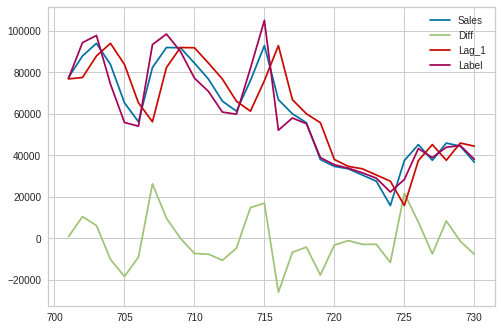

In [210]:
unseen_predictions.plot()

## In this section the answer the question in the assignment 📒 

In [256]:
# calculate sales in each month for the next year. The strftime function help us to convert the dats to a monthly base.
data = pd.DataFrame({'Date': df.Date.dt.strftime('%Y-%m'), 'Sales': df.Sales}) # copy df with only the Date and Sales columns
data = data.groupby('Date').sum().reset_index() # group the data based on the date then sum sales of each month.

window = 12 # the window to use 12 months

# sum the next year sales not including this month. for example 2012-1 will have a sum of the next 12 months starting from 2012-2
nextYear = []
for i in range(window,len(data)):
  nextYear.append(data.Sales[i:i+window].sum()) 

previousYear = []
mean = []
std = []
for i in range(len(data)):
  previousYear.append(data.Sales[i:i+window].sum()) # the previous year sales summation 
  mean.append(data.Sales[i:i+window].mean()) # the previous year sales mean
  std.append(data.Sales[i:i+window].std()) # the previous year sales standard deviation

# up dataing the 
data['Sales_N12_Sum'] = pd.Series(nextYear)
data['Sales_P12_Sum'] = pd.Series(previousYear)
data['Sales_P12_Mean'] = pd.Series(mean)
data['Sales_P12_Std'] = pd.Series(std)

data

Date         Sales  ...  Sales_P12_Mean  Sales_P12_Std
0   2012-01  1.767727e+06  ...    1.703692e+06  248195.941650
1   2012-02  1.491336e+06  ...    1.671670e+06  263500.269527
2   2012-03  1.620713e+06  ...    1.628379e+06  330081.790137
3   2012-04  1.515504e+06  ...    1.584406e+06  364545.480532
4   2012-05  1.639885e+06  ...    1.561487e+06  377680.482161
5   2012-06  1.660848e+06  ...    1.527848e+06  387900.884520
6   2012-07  1.655123e+06  ...    1.493569e+06  393218.475943
7   2012-08  1.590792e+06  ...    1.454392e+06  399036.323612
8   2012-09  1.500107e+06  ...    1.421425e+06  403063.794669
9   2012-10  1.587317e+06  ...    1.396640e+06  406911.857280
10  2012-11  2.242950e+06  ...    1.378704e+06  402462.286423
11  2012-12  2.172004e+06  ...    1.329072e+06  312967.354425
12  2013-01  1.383460e+06  ...    1.304091e+06  243914.984951
13  2013-02  9.718508e+05  ...    1.296876e+06  254473.499847
14  2013-03  1.093033e+06  ...    1.329379e+06  242981.943074
15  2013-04  1.240471e+06  ...    1.355639e+06  242202.388018
16  2013-05  1.236226e+06  ...    1.370035e+06  254775.578466
17  2013-06  1.249496e+06  ...    1.389151e+06  268921.072817
18  2013-07  1.184992e+06  ...    1.412427e+06  286760.231915
19  2013-08  1.195198e+06  ...    1.457914e+06  295417.201093
20  2013-09  1.202684e+06  ...    1.523593e+06  295979.185733
21  2013-10  1.372081e+06  ...    1.630562e+06  250500.807872
22  2013-11  1.647369e+06  ...    1.759803e+06  159004.832073
23  2013-12  1.872236e+06  ...    1.872236e+06            NaN

[24 rows x 6 columns]

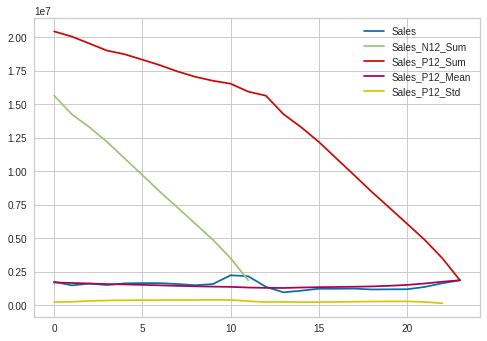

In [257]:
data.plot()

In [258]:
# split the data to unseen (test set) 20%
train = data.dropna()
unseen = train.loc[(len(train) * .8):]
unseen

Date         Sales  ...  Sales_P12_Mean  Sales_P12_Std
10  2012-11  2.242950e+06  ...    1.378704e+06  402462.286423
11  2012-12  2.172004e+06  ...    1.329072e+06  312967.354425

[2 rows x 6 columns]

In [259]:
# split the data to train 80%
train = train.loc[:(len(train) * 0.8)]
train

Date         Sales  ...  Sales_P12_Mean  Sales_P12_Std
0  2012-01  1.767727e+06  ...    1.703692e+06  248195.941650
1  2012-02  1.491336e+06  ...    1.671670e+06  263500.269527
2  2012-03  1.620713e+06  ...    1.628379e+06  330081.790137
3  2012-04  1.515504e+06  ...    1.584406e+06  364545.480532
4  2012-05  1.639885e+06  ...    1.561487e+06  377680.482161
5  2012-06  1.660848e+06  ...    1.527848e+06  387900.884520
6  2012-07  1.655123e+06  ...    1.493569e+06  393218.475943
7  2012-08  1.590792e+06  ...    1.454392e+06  399036.323612
8  2012-09  1.500107e+06  ...    1.421425e+06  403063.794669
9  2012-10  1.587317e+06  ...    1.396640e+06  406911.857280

[10 rows x 6 columns]

In [260]:
# info and describe the train data
display(train.info())
print('\n\n')
display(train.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10 non-null     object 
 1   Sales           10 non-null     float64
 2   Sales_N12_Sum   10 non-null     float64
 3   Sales_P12_Sum   10 non-null     float64
 4   Sales_P12_Mean  10 non-null     float64
 5   Sales_P12_Std   10 non-null     float64
dtypes: float64(5), object(1)
memory usage: 560.0+ bytes


None

Sales  Sales_N12_Sum  ...  Sales_P12_Mean  Sales_P12_Std
count  1.000000e+01   1.000000e+01  ...    1.000000e+01      10.000000
mean   1.602935e+06   1.028438e+07  ...    1.544351e+06  357413.530003
std    8.562105e+04   3.605737e+06  ...    1.045793e+05   58151.890316
min    1.491336e+06   4.891687e+06  ...    1.396640e+06  248195.941650
25%    1.533457e+06   7.585817e+06  ...    1.464186e+06  338697.712736
50%    1.605752e+06   1.034217e+07  ...    1.544668e+06  382790.683340
75%    1.651314e+06   1.302053e+07  ...    1.617386e+06  397581.861695
max    1.767727e+06   1.564910e+07  ...    1.703692e+06  406911.857280

[8 rows x 5 columns]

In [261]:
# info and describe the unseen data
display(unseen.info())
print('\n\n')
display(unseen.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 10 to 11
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2 non-null      object 
 1   Sales           2 non-null      float64
 2   Sales_N12_Sum   2 non-null      float64
 3   Sales_P12_Sum   2 non-null      float64
 4   Sales_P12_Mean  2 non-null      float64
 5   Sales_P12_Std   2 non-null      float64
dtypes: float64(5), object(1)
memory usage: 112.0+ bytes


None

Sales  Sales_N12_Sum  ...  Sales_P12_Mean  Sales_P12_Std
count  2.000000e+00   2.000000e+00  ...    2.000000e+00       2.000000
mean   2.207477e+06   2.695921e+06  ...    1.353888e+06  357714.820424
std    5.016700e+04   1.164866e+06  ...    3.509494e+04   63282.473298
min    2.172004e+06   1.872236e+06  ...    1.329072e+06  312967.354425
25%    2.189740e+06   2.284079e+06  ...    1.341480e+06  335341.087424
50%    2.207477e+06   2.695921e+06  ...    1.353888e+06  357714.820424
75%    2.225214e+06   3.107763e+06  ...    1.366296e+06  380088.553423
max    2.242950e+06   3.519606e+06  ...    1.378704e+06  402462.286423

[8 rows x 5 columns]

In [262]:
# initialize the setup for pycaret
s = setup(train, target = 'Sales_N12_Sum', normalize=True, transformation=True, ignore_features=['Date'],
          data_split_shuffle= False, fold_strategy = 'timeseries', fold = 3, transform_target = True, session_id = 123)

Description             Value
0                               session_id               123
1                                   Target     Sales_N12_Sum
2                            Original Data           (10, 6)
3                           Missing Values             False
4                         Numeric Features                 4
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set            (6, 3)
10                    Transformed Test Set            (4, 3)
11                      Shuffle Train-Test             False
12                     Stratify Train-Test             False
13                          Fold Generator   TimeSeriesSplit
14                             Fold Number                 3
15                                CPU Jobs                -1
16                                 Use GPU             False
17                          Log Experiment             False
18                         Experiment Name  reg-default-name
19                                     USI              1479
20                         Imputation Type            simple
21          Iterative Imputation Iteration              None
22                         Numeric Imputer              mean
23      Iterative Imputation Numeric Model              None
24                     Categorical Imputer          constant
25  Iterative Imputation Categorical Model              None
26           Unknown Categoricals Handling    least_frequent
27                               Normalize              True
28                        Normalize Method            zscore
29                          Transformation              True
30                   Transformation Method       yeo-johnson
31                                     PCA             False
32                              PCA Method              None
33                          PCA Components              None
34                     Ignore Low Variance             False
35                     Combine Rare Levels             False
36                    Rare Level Threshold              None
37                         Numeric Binning             False
38                         Remove Outliers             False
39                      Outliers Threshold              None
40                Remove Multicollinearity             False
41             Multicollinearity Threshold              None
42                              Clustering             False
43                    Clustering Iteration              None
44                     Polynomial Features             False
45                       Polynomial Degree              None
46                    Trignometry Features             False
47                    Polynomial Threshold              None
48                          Group Features             False
49                       Feature Selection             False
50                Feature Selection Method           classic
51            Features Selection Threshold              None
52                     Feature Interaction             False
53                           Feature Ratio             False
54                   Interaction Threshold              None
55                        Transform Target              True
56                 Transform Target Method           box-cox

In [263]:
# the models available in pycaret 23 one
models()

Name  ...  Turbo
ID                                           ...       
lr                        Linear Regression  ...   True
lasso                      Lasso Regression  ...   True
ridge                      Ridge Regression  ...   True
en                              Elastic Net  ...   True
lar                  Least Angle Regression  ...   True
llar           Lasso Least Angle Regression  ...   True
omp             Orthogonal Matching Pursuit  ...   True
br                           Bayesian Ridge  ...   True
ard       Automatic Relevance Determination  ...  False
par            Passive Aggressive Regressor  ...   True
ransac              Random Sample Consensus  ...  False
tr                       TheilSen Regressor  ...  False
huber                       Huber Regressor  ...   True
kr                             Kernel Ridge  ...  False
svm               Support Vector Regression  ...  False
knn                   K Neighbors Regressor  ...   True
dt                  Decision Tree Regressor  ...   True
rf                  Random Forest Regressor  ...   True
et                    Extra Trees Regressor  ...   True
ada                      AdaBoost Regressor  ...   True
gbr             Gradient Boosting Regressor  ...   True
mlp                           MLP Regressor  ...  False
lightgbm    Light Gradient Boosting Machine  ...   True

[23 rows x 3 columns]

In [264]:
# compare all the 23 models and return the best one with MAerror
best = compare_models(sort= 'MAE')

Model           MAE           MSE  \
omp           Orthogonal Matching Pursuit  3.641899e+05  1.665395e+11   
lar                Least Angle Regression  3.769769e+05  2.464447e+11   
br                         Bayesian Ridge  5.881917e+05  5.066323e+11   
huber                     Huber Regressor  6.642804e+05  6.499417e+11   
par          Passive Aggressive Regressor  8.855589e+05  8.838490e+11   
ada                    AdaBoost Regressor  1.203215e+06  1.450197e+12   
gbr           Gradient Boosting Regressor  1.430771e+06  2.084373e+12   
et                  Extra Trees Regressor  1.457578e+06  2.177371e+12   
dt                Decision Tree Regressor  1.567559e+06  2.752355e+12   
rf                Random Forest Regressor  1.824657e+06  3.355414e+12   
lightgbm  Light Gradient Boosting Machine  2.816547e+06  8.250640e+12   
llar         Lasso Least Angle Regression  2.816547e+06  8.250641e+12   

                  RMSE  R2   RMSLE    MAPE  TT (Sec)  
omp       3.641899e+05 NaN  0.0335  0.0342    0.0200  
lar       3.769769e+05 NaN  0.0384  0.0372    0.9000  
br        5.881917e+05 NaN  0.0543  0.0565    0.0233  
huber     6.642804e+05 NaN  0.0636  0.0638    0.0400  
par       8.855589e+05 NaN  0.0802  0.0842    0.0233  
ada       1.203215e+06 NaN  0.1052  0.1111    0.0333  
gbr       1.430771e+06 NaN  0.1231  0.1311    0.0467  
et        1.457578e+06 NaN  0.1252  0.1336    0.3333  
dt        1.567559e+06 NaN  0.1338  0.1443    0.9067  
rf        1.824657e+06 NaN  0.1560  0.1692    0.4000  
lightgbm  2.816547e+06 NaN  0.2324  0.2640    0.1800  
llar      2.816547e+06 NaN  0.2324  0.2640    0.0233

In [265]:
# a prediction on the train data
prediction_holdout = predict_model(best)

Model          MAE  ...   RMSLE    MAPE
0  Orthogonal Matching Pursuit  138013.0306  ...  0.0354  0.0239

[1 rows x 7 columns]

In [266]:
# create the best model with 5 fold test
best = create_model(best, fold = 5)

MAE           MSE          RMSE   R2   RMSLE    MAPE
0    -0.000000e+00 -0.000000e+00 -0.000000e+00  0.0 -0.0000 -0.0000
1     1.623842e+06  2.636863e+12  1.623842e+06  NaN  0.1152  0.1222
2     1.389257e+05  1.930034e+10  1.389257e+05  NaN  0.0113  0.0114
3     5.899587e+05  3.480512e+11  5.899587e+05  NaN  0.0524  0.0538
4     3.636854e+05  1.322671e+11  3.636854e+05  NaN  0.0367  0.0374
Mean  5.432824e+05  6.272964e+11  5.432824e+05  NaN  0.0431  0.0450
SD    5.763165e+05  1.012379e+12  5.763165e+05  NaN  0.0405  0.0430

In [267]:
# hyperparameters tuning
tuned = tune_model(best, n_iter = 50)

MAE           MSE         RMSE  R2   RMSLE    MAPE
0     138925.6517  1.930034e+10  138925.6517 NaN  0.0113  0.0114
1     589958.6547  3.480512e+11  589958.6547 NaN  0.0524  0.0538
2     363685.4129  1.322671e+11  363685.4129 NaN  0.0367  0.0374
Mean  364189.9064  1.665395e+11  364189.9064 NaN  0.0335  0.0342
SD    184133.7980  1.363824e+11  184133.7980 NaN  0.0169  0.0175

In [268]:
# plot the parameters 
plot_model(tuned, plot = 'parameter')

Parameters
fit_intercept                                                               True
n_nonzero_coefs                                                                1
normalize                                                                   True
precompute                                                                  auto
tol                                                                         None
power_transformer_method                                                 box-cox
power_transformer_standardize                                               True
regressor                      OrthogonalMatchingPursuit(fit_intercept=True, ...

In [269]:
# evaluate the model on the train data
evaluate_model(tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [270]:
# bagging the model 
bagged = ensemble_model(tuned, method = 'Bagging')

MAE           MSE          RMSE  R2   RMSLE    MAPE
0     1.132948e+06  1.283571e+12  1.132948e+06 NaN  0.0888  0.0929
1     7.494993e+05  5.617492e+11  7.494993e+05 NaN  0.0661  0.0684
2     4.237917e+05  1.795994e+11  4.237917e+05 NaN  0.0427  0.0436
Mean  7.687463e+05  6.749732e+11  7.687463e+05 NaN  0.0659  0.0683
SD    2.898315e+05  4.577503e+11  2.898315e+05 NaN  0.0188  0.0201

In [271]:
# unseen predictions
unseen_predictions = predict_model(bagged, data=unseen)
unseen_predictions.head()

Date         Sales  ...  Sales_P12_Std         Label
10  2012-11  2.242950e+06  ...  402462.286423  4.499611e+06
11  2012-12  2.172004e+06  ...  312967.354425  2.813767e+06

[2 rows x 7 columns]

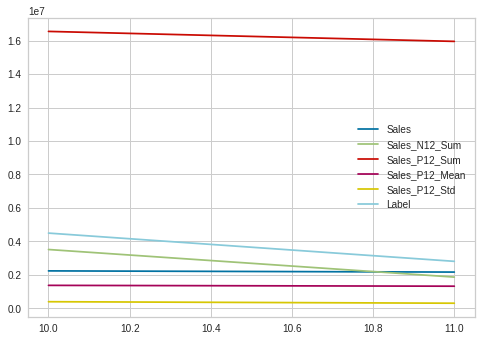

In [272]:
# plot the unseen predictions
unseen_predictions.plot()

In [273]:
# check metrics change the MAE to any matric
check_metric(unseen_predictions.Sales_N12_Sum, unseen_predictions.Label, 'MAE')

960768.3008

In [274]:
# the data is nan after 2013 because it is the sum of the next year so no more data ☹
data

Date         Sales  ...  Sales_P12_Mean  Sales_P12_Std
0   2012-01  1.767727e+06  ...    1.703692e+06  248195.941650
1   2012-02  1.491336e+06  ...    1.671670e+06  263500.269527
2   2012-03  1.620713e+06  ...    1.628379e+06  330081.790137
3   2012-04  1.515504e+06  ...    1.584406e+06  364545.480532
4   2012-05  1.639885e+06  ...    1.561487e+06  377680.482161
5   2012-06  1.660848e+06  ...    1.527848e+06  387900.884520
6   2012-07  1.655123e+06  ...    1.493569e+06  393218.475943
7   2012-08  1.590792e+06  ...    1.454392e+06  399036.323612
8   2012-09  1.500107e+06  ...    1.421425e+06  403063.794669
9   2012-10  1.587317e+06  ...    1.396640e+06  406911.857280
10  2012-11  2.242950e+06  ...    1.378704e+06  402462.286423
11  2012-12  2.172004e+06  ...    1.329072e+06  312967.354425
12  2013-01  1.383460e+06  ...    1.304091e+06  243914.984951
13  2013-02  9.718508e+05  ...    1.296876e+06  254473.499847
14  2013-03  1.093033e+06  ...    1.329379e+06  242981.943074
15  2013-04  1.240471e+06  ...    1.355639e+06  242202.388018
16  2013-05  1.236226e+06  ...    1.370035e+06  254775.578466
17  2013-06  1.249496e+06  ...    1.389151e+06  268921.072817
18  2013-07  1.184992e+06  ...    1.412427e+06  286760.231915
19  2013-08  1.195198e+06  ...    1.457914e+06  295417.201093
20  2013-09  1.202684e+06  ...    1.523593e+06  295979.185733
21  2013-10  1.372081e+06  ...    1.630562e+06  250500.807872
22  2013-11  1.647369e+06  ...    1.759803e+06  159004.832073
23  2013-12  1.872236e+06  ...    1.872236e+06            NaN

[24 rows x 6 columns]

In [275]:
# predictaion for the month 2013-1 or untal that month.
# in the output we can see the labels aka the perdications.
# the month 2013-1 now have a next year totol of sales.
new = predict_model(bagged, data=data[:13].drop('Sales_N12_Sum', axis=1))
new

Date         Sales  ...  Sales_P12_Std         Label
0   2012-01  1.767727e+06  ...  248195.941650  1.569824e+07
1   2012-02  1.491336e+06  ...  263500.269527  1.472686e+07
2   2012-03  1.620713e+06  ...  330081.790137  1.336565e+07
3   2012-04  1.515504e+06  ...  364545.480532  1.188935e+07
4   2012-05  1.639885e+06  ...  377680.482161  1.108452e+07
5   2012-06  1.660848e+06  ...  387900.884520  9.878470e+06
6   2012-07  1.655123e+06  ...  393218.475943  8.633285e+06
7   2012-08  1.590792e+06  ...  399036.323612  7.206470e+06
8   2012-09  1.500107e+06  ...  403063.794669  6.014647e+06
9   2012-10  1.587317e+06  ...  406911.857280  5.130338e+06
10  2012-11  2.242950e+06  ...  402462.286423  4.499611e+06
11  2012-12  2.172004e+06  ...  312967.354425  2.813767e+06
12  2013-01  1.383460e+06  ...  243914.984951  2.012525e+06

[13 rows x 6 columns]

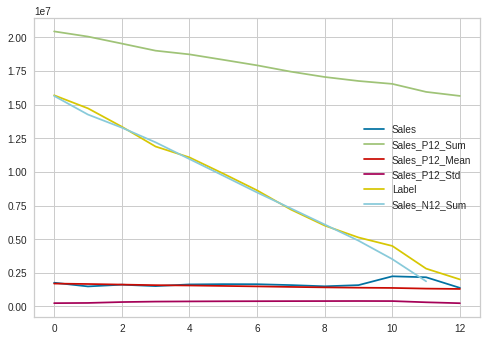

In [276]:
# plot the new predictaion index 12 is the important part
new['Sales_N12_Sum'] = data.Sales_N12_Sum.dropna()
new.plot()

## Sklearn manual model Just because 😃

In [277]:
# everything here is an extra to show that i can code as well.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
model = LinearRegression()

model = model.fit(train.drop(['Sales_N12_Sum', 'Date'], axis=1), train.Sales_N12_Sum)
print('model confficient %s ' % (model.score(train.drop(['Sales_N12_Sum', 'Date'], axis=1), train.Sales_N12_Sum) * 100))
pred = model.predict(unseen.drop(['Sales_N12_Sum', 'Date'], axis=1))
print('mas of the model %s' % mae(unseen.Sales_N12_Sum, pred))
display(unseen.Sales_N12_Sum.values, pred)

model confficient 99.78198288924399 
mas of the model 493179.28500028397


array([3519605.64999875, 1872236.21999932])

array([3891779.2123109, 1258051.2123109])